In [2]:
from ultralytics import YOLO
from IPython.display import Image
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# モデルの読み込み
model = YOLO("yolov8x.pt")

100%|██████████| 131M/131M [00:13<00:00, 10.1MB/s] 


## lossが順調に下がっているのでもう少しepoch数を重ねてみる

In [6]:
# データセットの学習
# 前回の学習時は少し過学習気味だったのでdropout=0.1を入れてみる
# 前回の学習時はlossが下がって、さらに下がりそうだった。よって今回は400epochsにしてみる
results = model.train(data="data.yaml", epochs=400, imgsz=416, device=0, plots=True, dropout=0.1)

Ultralytics YOLOv8.2.2  Python-3.10.14 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning C:\Users\yuuki\Kaggle\object_detection_try\shellfish_v2\after_data\train\labels.cache... 406 images, 0 backgrounds, 0 corrupt: 100%|██████████| 406/406 [00:00<?, ?it/s]
val: Scanning C:\Users\yuuki\Kaggle\object_detection_try\shellfish_v2\after_data\valid\labels... 116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 116/116 [00:00<00:00, 1318.13it/s]

val: New cache created: C:\Users\yuuki\Kaggle\object_detection_try\shellfish_v2\after_data\valid\labels.cache


## 正解データと検証データの比較

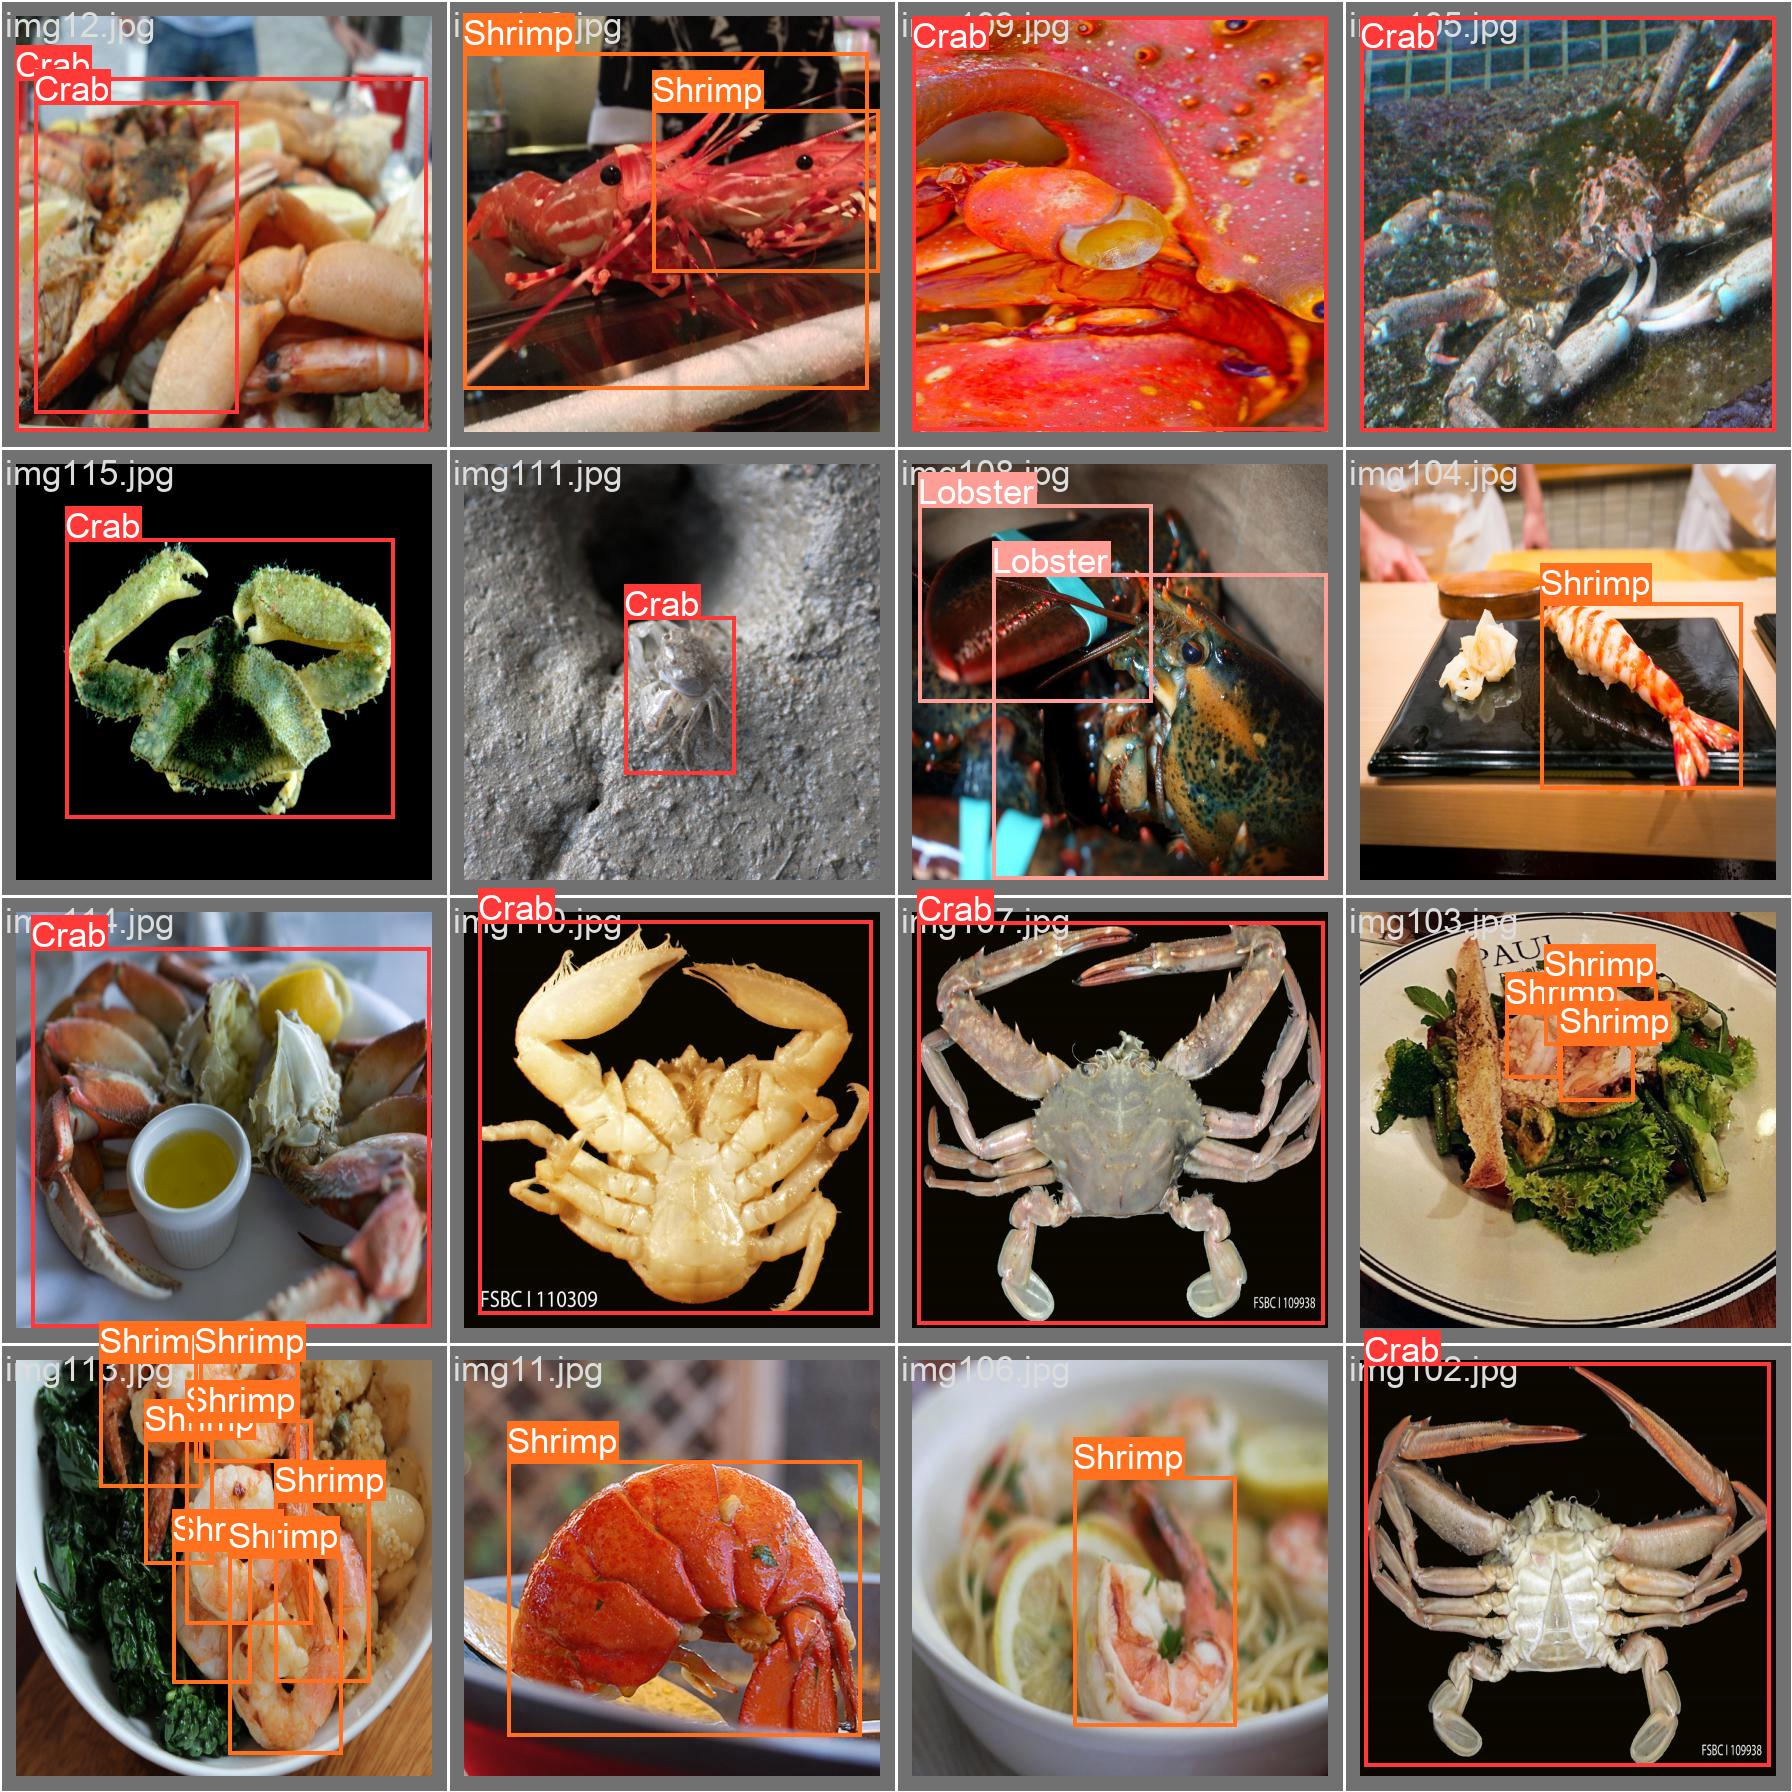

In [7]:
# 正解データ
Image("runs/detect/train2/val_batch2_labels.jpg")

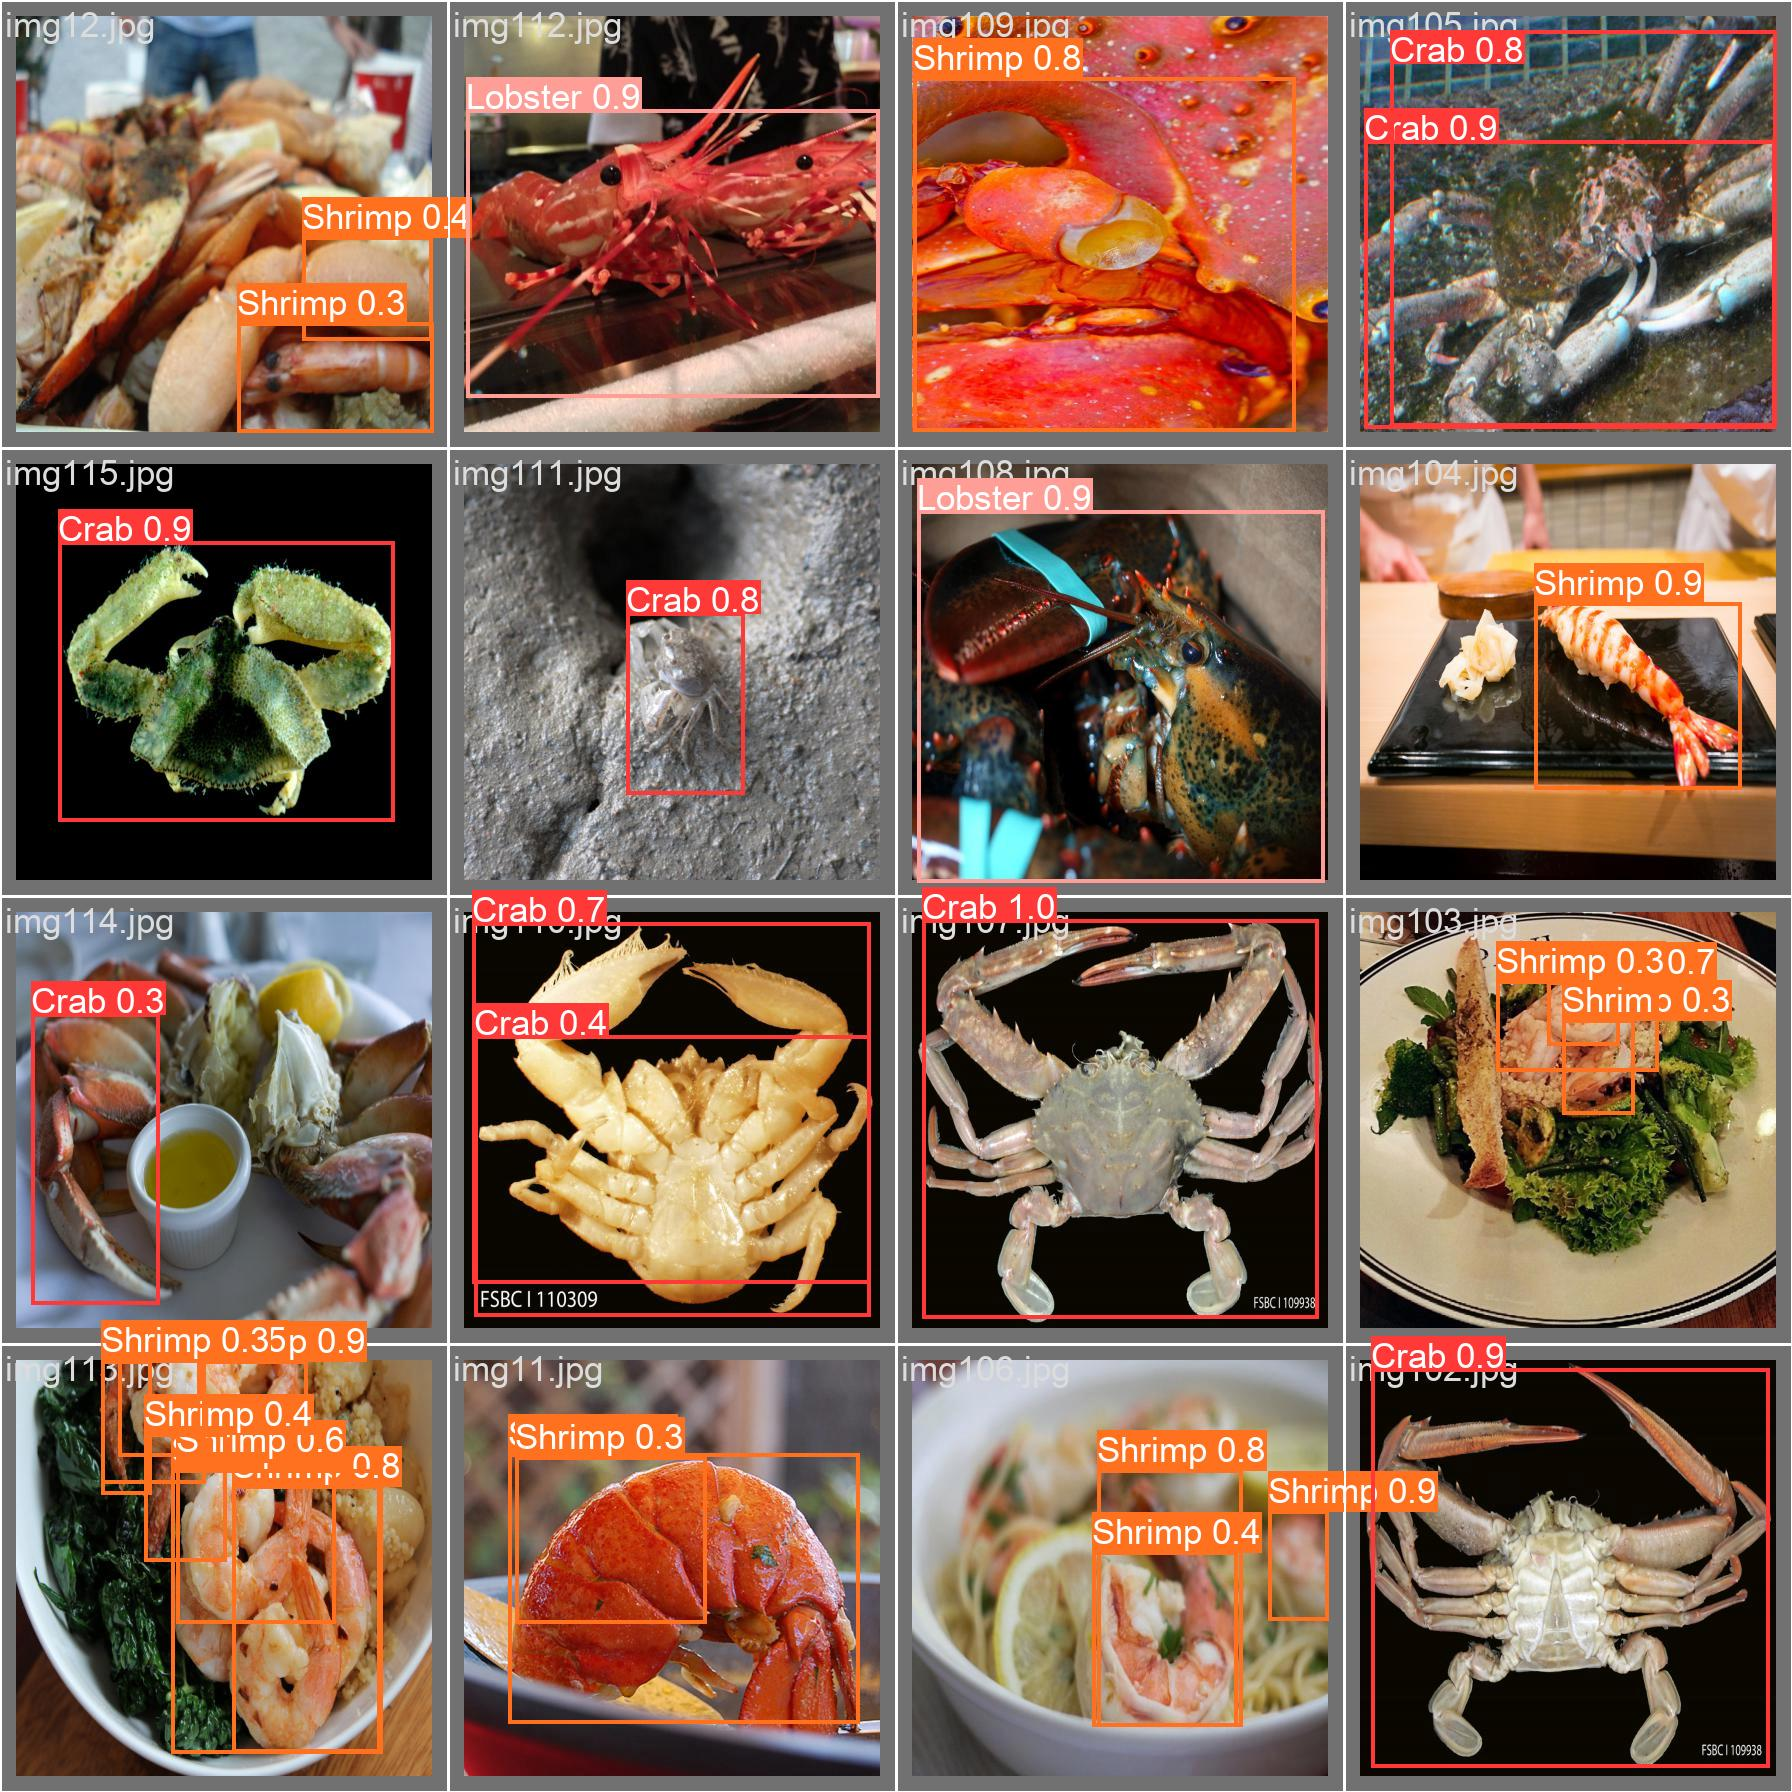

In [8]:
# 検証データ
Image("runs/detect/train2/val_batch2_pred.jpg")

## F1 Curve

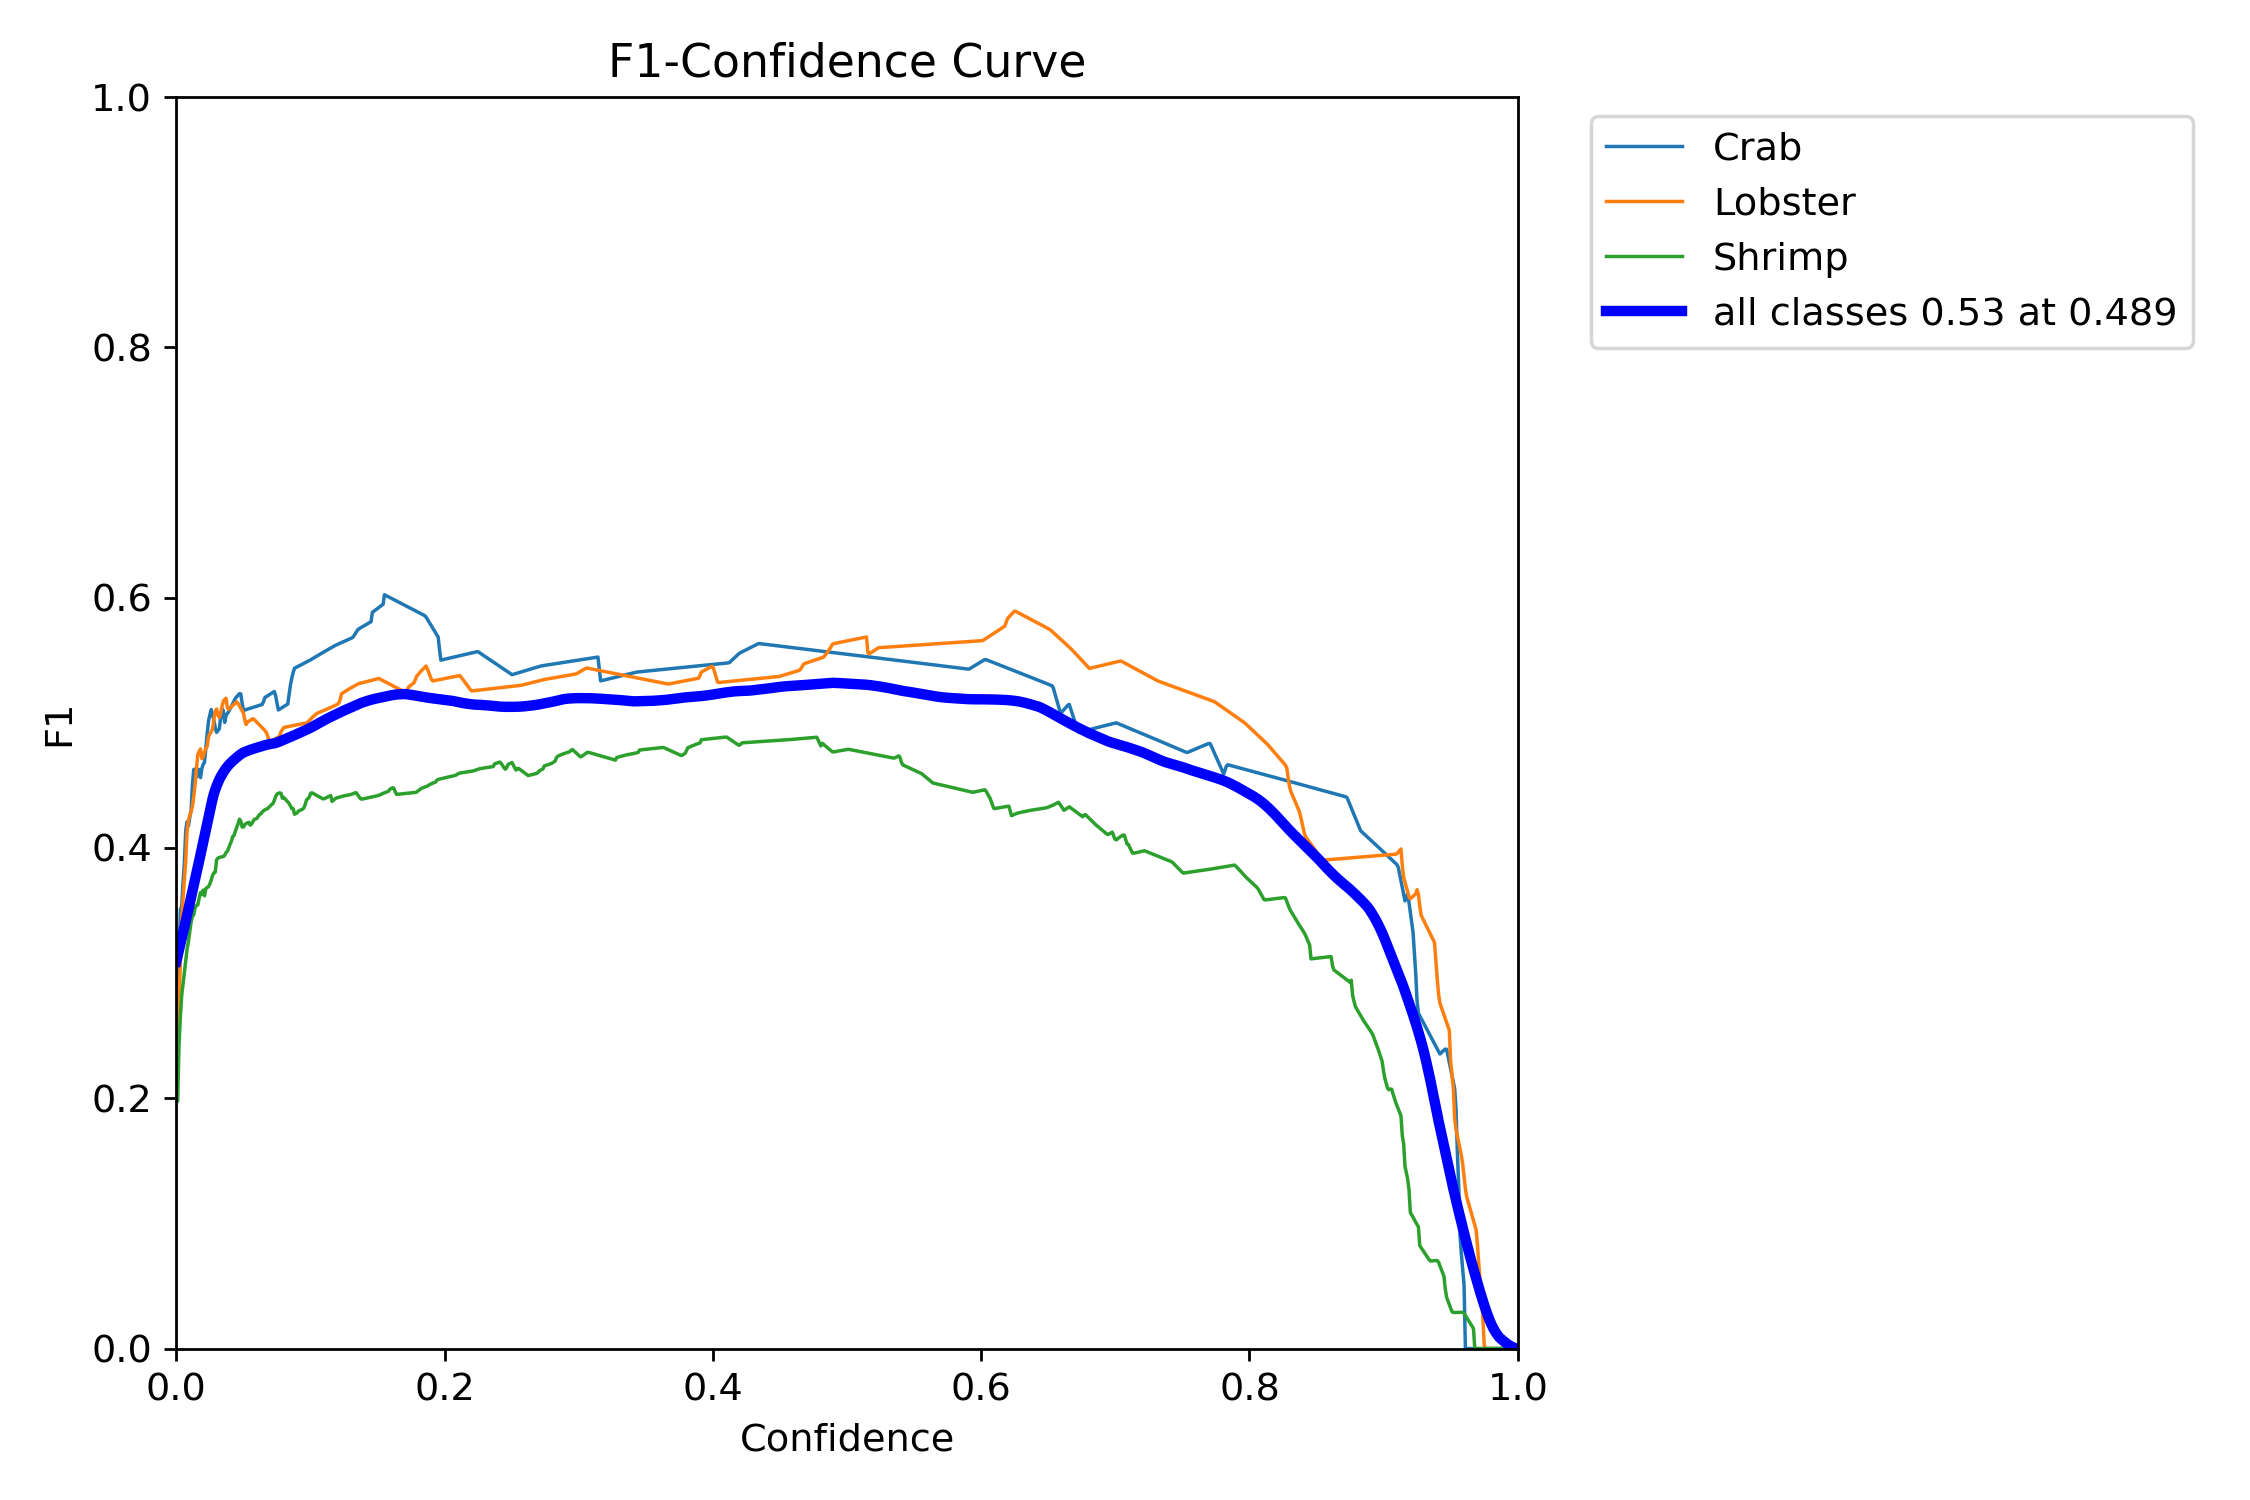

In [5]:
Image("runs/detect/train2/F1_curve.png")

## F1-Confidence curve の "all classes 0.53 at 0.489" という評価結果について
F1-Confidence curve は、物体検出や画像分類などのタスクにおいて、検出モデルの性能を評価するために用いられる指標です。"all classes 0.53 at 0.489" は、すべてのクラス に関する F1スコア (0.53) が confidence閾値0.489 で達成されることを意味します。  

詳細な説明:  

all classes: この表記は、すべてのクラス を対象としていることを示します。つまり、F1-Confidence curve は個々のクラスではなく、すべてのクラスをまとめて評価しています。
0.53 at 0.489: この表記は、F1スコア の値が 0.53 であり、confidence閾値が0.489 であることを示します。  
F1スコア は、精度と再現性のバランスを考慮した指標で、0 から 1 の範囲 で、1 に近いほど高い精度と再現性を示します。confidence閾値 は、物体検出における判定基準となる物体スコア (confidence) の閾値です。  

0.53 at 0.489 という評価結果は、以下のことを意味します。  

このモデルは、すべてのクラスにおいて、confidence閾値が 0.489 の場合、F1スコアが 0.53 を達成している。  
つまり、このモデルは、すべてのクラスにおいて、confidence閾値が 0.489 の場合、精度と再現性のバランスが取れていると言える。

## P-R Curve

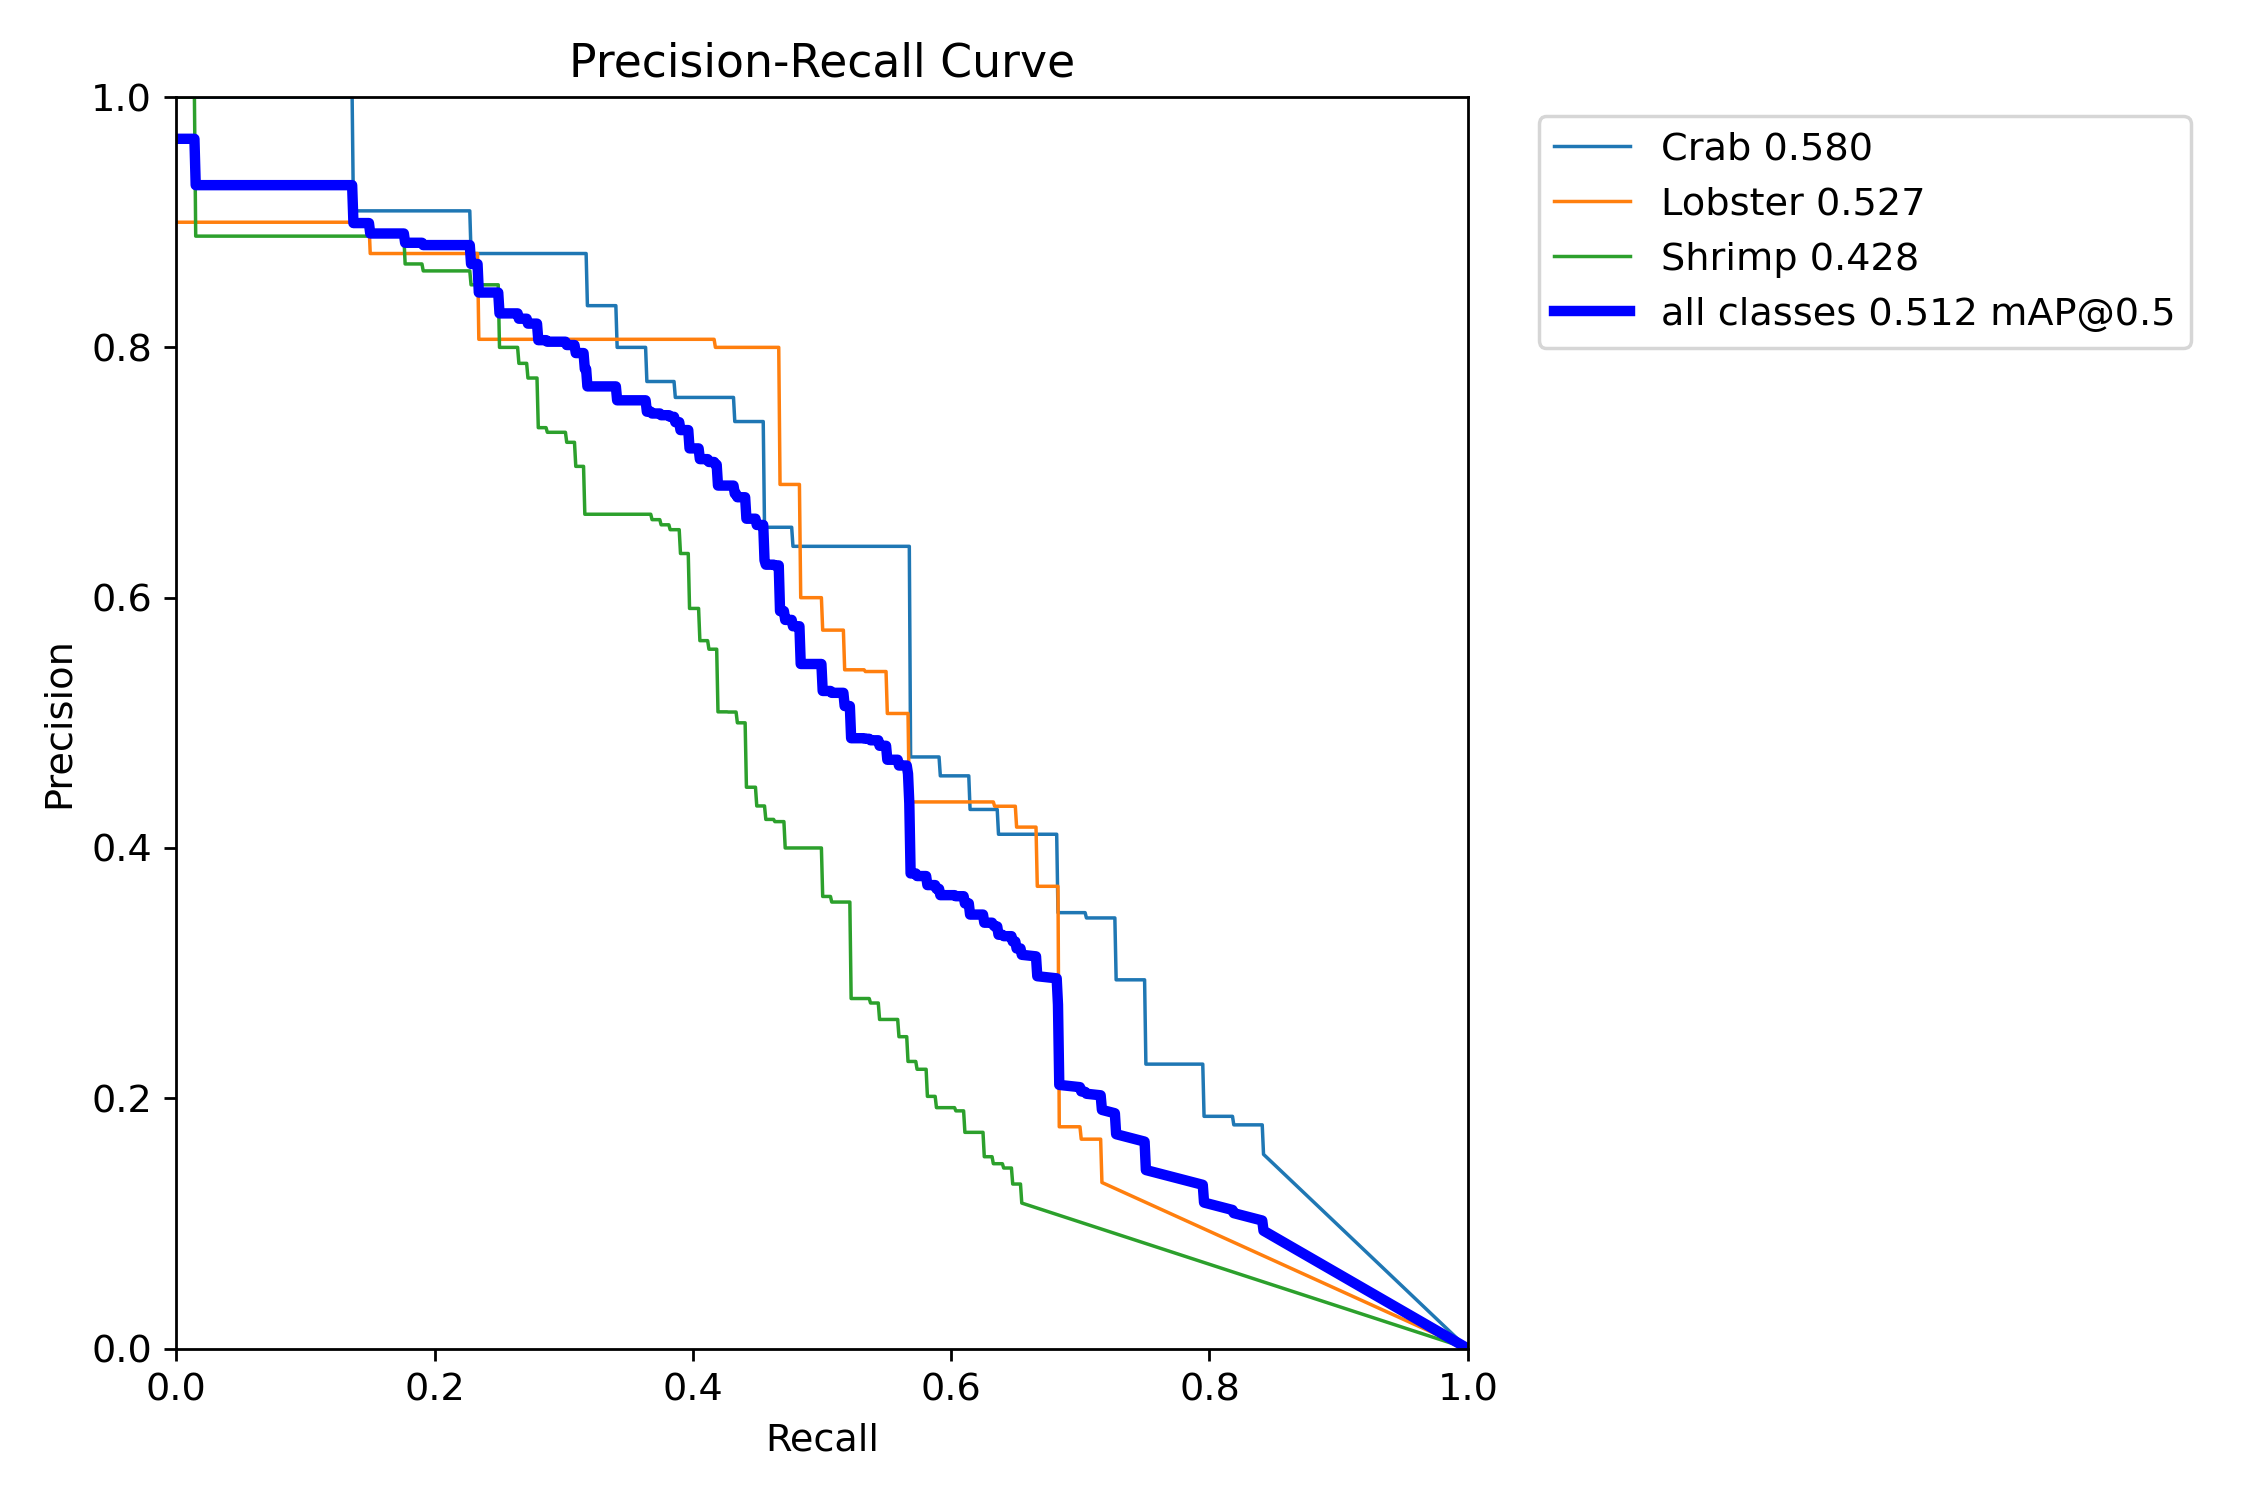

In [6]:
Image("runs/detect/train2/PR_curve.png")

## P-R Curveの"all classes 0.512 mAP@0.5" という評価結果について
すべてのクラス における 平均精度 (mAP) が 0.512 であり、IoU閾値が0.5 であることを示します。

詳細な説明:

all classes: この表記は、すべてのクラス を対象としていることを示します。つまり、評価対象は特定のクラスではなく、すべてのクラス をまとめて評価しています。
0.512 mAP@0.5: この表記は、mAP (mean Average Precision) の値が 0.512 であり、IoU閾値が0.5 であることを示します。
mAP (mean Average Precision) は、Precision-Recall curve (PRC) 曲線下積の平均値で、精度と再現性のバランスを考慮した指標です。IoU 閾値は、物体検出における判定基準となる重複率 (Intersection over Union) の閾値です。

0.512 mAP@0.5 という評価結果は、以下のことを意味します。

YOLOv8 モデルは、すべてのクラス において、IoU 閾値が 0.5 の場合、平均精度が 0.512 を達成している。
つまり、このモデルは、**すべてのクラスにおいて、IoU 閾値が 0.5 の場合、精度と再現性のバランスが取れていると言える。

## モデルの評価
このYOLOv8 モデルは、すべてのクラスにおいて、IoU 閾値が 0.5 の場合、平均精度が 0.512 を達成している。つまり、このモデルは、すべてのクラスにおいて、IoU 閾値が 0.5 の場合、精度と再現性のバランスが取れていると言えます。

## onnx形式でモデルを保存

In [11]:
# best_modelの読み込み
best_model = YOLO("runs/detect/train2/weights/best.pt")
# 保存
best_model.export(format="onnx")

Ultralytics YOLOv8.2.2  Python-3.10.14 torch-2.2.2+cu118 CPU (13th Gen Intel Core(TM) i7-13700HX)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'runs\detect\train2\weights\best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 7, 3549) (130.4 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success  3.1s, saved as 'runs\detect\train2\weights\best.onnx' (260.0 MB)

Export complete (6.6s)
Results saved to C:\Users\yuuki\Kaggle\object_detection_try\shellfish\runs\detect\train2\weights
Predict:         yolo predict task=detect model=runs\detect\train2\weights\best.onnx imgsz=416  
Validate:        yolo val task=detect model=runs\detect\train2\weights\best.onnx imgsz=416 data=data_rev1.yaml  
Visualize:       https://netron.app


'runs\\detect\\train2\\weights\\best.onnx'